In [2]:

!pip install -q timm albumentations

from google.colab import drive
drive.mount("/content/drive")

import os
# 設定你的專案資料夾路徑
datadir = "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/"
if not os.path.exists("project"):
    os.symlink(datadir, "project")
os.chdir("project")
print("Working dir:", os.getcwd())

Mounted at /content/drive
Working dir: /content/drive/Shareddrives/CS444 DLCV 抱團/Final Project


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/data2/__MACOSX/train/._e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: /content/data2/train/8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._8058dc12-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._edf9faa6-bbb7-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/train/f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/__MACOSX/train/._f721d41e-bb9e-11e8-b2b9-ac1f6b6435d0_green.png  
  inflating: /content/data2/train/3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/__MACOSX/train/._3d9ef3aa-bbbc-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: /content/data2/train/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: /content/data2/__MACOSX/train/._e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  infla

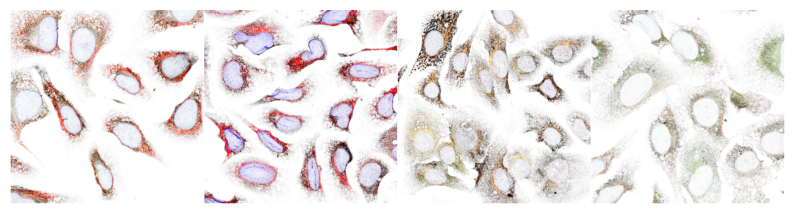

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


[Epoch 1, Batch 100] Loss: 0.000, Acc: 94.18%, f1: 0.06 Time: 181.45s


KeyboardInterrupt: 

KeyboardInterrupt: 

In [3]:
 %run ResNet_18_34.ipynb


In [ ]:
#tryyy

In [4]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torch.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
vit.conv_proj = nn.Conv2d(4, vit.conv_proj.out_channels, kernel_size=vit.conv_proj.kernel_size, stride=vit.conv_proj.stride, padding=vit.conv_proj.padding)
vit.heads.head = nn.Linear(vit.heads.head.in_features, train_dataset.num_classes)
model = nn.Sequential(nn.Upsample((224, 224), mode='bilinear', align_corners=False), vit).to(device)

# Loss (with pos_weight)
with torch.no_grad():
    all_trues = []
    for _, labels in val_loader:
        all_trues.append(labels.numpy())
    pos_counts = np.vstack(all_trues).sum(axis=0) + 1
    pos_weight = torch.tensor(1.0 / pos_counts, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
scaler = GradScaler()


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 55.6MB/s]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

# --- 1) DataLoader（回归最简单版本）---
train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=16,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:


# --- 2) Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p_t = torch.exp(-bce)
        fl = (1 - p_t)**self.gamma * bce
        return fl.mean() if self.reduction=='mean' else fl.sum()

criterion = FocalLoss(gamma=2.0)

# --- 3) ViT-B/16（4 channel + 28 category）---
vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
old = vit.conv_proj
vit.conv_proj = nn.Conv2d(
    in_channels=4,
    out_channels=old.out_channels,
    kernel_size=old.kernel_size,
    stride=old.stride,
    padding=old.padding,
    bias=(old.bias is not None)
)
vit.heads.head = nn.Linear(vit.heads.head.in_features, train_dataset.num_classes)

model = nn.Sequential(
    nn.Upsample((224,224), mode='bilinear', align_corners=False),
    vit
).to(device)

# --- 4) ---
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# --- 5) train Loop (10 epochs) + prediction ---
best_val_loss = float('inf')
for epoch in range(1, 11):
    # Train
    model.train()
    total_tr = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_tr += loss.item() * imgs.size(0)
    train_loss = total_tr / len(train_loader.dataset)

    # Val
    model.eval()
    total_va = 0.0
    all_probs = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            total_va += criterion(logits, labels.to(device)).item() * imgs.size(0)
            all_probs.append(torch.sigmoid(logits).cpu().numpy())
    val_loss = total_va / len(val_loader.dataset)

    # prediction
    probs = np.vstack(all_probs)
    pos_rate = (probs > 0.5).mean()

    print(f"[Epoch {epoch:02d}]  tr_loss={train_loss:.4f}  va_loss={val_loss:.4f}  pos_rate={pos_rate:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "vit_b16_focal_baseline.pth")

torch.cuda.empty_cache()

# --- 6) threshold + Macro F1 ---
model.load_state_dict(torch.load("vit_b16_focal_baseline.pth"))
model.eval()

#
all_preds, all_true = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        all_preds.append(torch.sigmoid(logits).cpu().numpy())
        all_true.append(labels.numpy())
all_preds = np.vstack(all_preds)
all_true  = np.vstack(all_true)

# per-class best threshold
best_ths, _ = [], []
for c in range(all_true.shape[1]):
    best_f1, best_t = 0.0, 0.5
    for t in np.linspace(0.01, 0.99, 99):
        f1 = f1_score(all_true[:,c], (all_preds[:,c]>t).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_ths.append(best_t)

#  Macro F1
calibrated = (all_preds > best_ths).astype(int)
macro_f1 = f1_score(all_true, calibrated, average='macro', zero_division=0)

print("Best thresholds:", np.round(best_ths,2))
print(f"Calibrated Macro F1: {macro_f1:.4f}")


[Epoch 01]  tr_loss=0.0431  va_loss=0.0396  pos_rate=0.0194
[Epoch 02]  tr_loss=0.0385  va_loss=0.0367  pos_rate=0.0236
[Epoch 03]  tr_loss=0.0360  va_loss=0.0345  pos_rate=0.0301
[Epoch 04]  tr_loss=0.0345  va_loss=0.0338  pos_rate=0.0296
[Epoch 05]  tr_loss=0.0334  va_loss=0.0325  pos_rate=0.0329
[Epoch 06]  tr_loss=0.0324  va_loss=0.0329  pos_rate=0.0353
[Epoch 07]  tr_loss=0.0316  va_loss=0.0318  pos_rate=0.0342
[Epoch 08]  tr_loss=0.0305  va_loss=0.0309  pos_rate=0.0355
[Epoch 09]  tr_loss=0.0298  va_loss=0.0308  pos_rate=0.0403
[Epoch 10]  tr_loss=0.0289  va_loss=0.0305  pos_rate=0.0406
Best thresholds: [0.48 0.51 0.36 0.39 0.37 0.36 0.41 0.4  0.23 0.32 0.34 0.35 0.46 0.4
 0.4  0.09 0.34 0.48 0.32 0.31 0.26 0.45 0.44 0.34 0.25 0.46 0.37 0.5 ]
Calibrated Macro F1: 0.4209


In [5]:

!unzip -l "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/test.zip" | awk '{print $4}' | grep '\.csv$'


sample_submission.csv
__MACOSX/._sample_submission.csv


In [6]:
# 2. only unzip test.csv to /content/data2
!unzip -j "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/test.zip" "test.csv" -d "/content/data2"


Archive:  /content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/test.zip
caution: filename not matched:  test.csv


In [14]:
# 1) unzip test.zip if you haven’t already
!unzip -n "/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/test.zip" \
      -d "/content/data2"

import os, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights

# 2) load sample_submission.csv
DATA_DIR = "/content/data2"
subm = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

# 3) test‐time Dataset
class ProteinTestDataset(Dataset):
    def __init__(self, ids, img_dir, transform):
        self.ids = ids
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red','green','blue','yellow']
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        img_id = self.ids[i]
        chans = []
        for c in self.colors:
            p = os.path.join(self.img_dir, f"{img_id}_{c}.png")
            im = Image.open(p).convert('L')
            chans.append(np.array(im))
        img = np.stack(chans, axis=-1)  # H×W×4
        # Albumentations expects a dict:
        img = self.transform(image=img)['image']
        return img, img_id

# 4) same preprocessing as validation
test_tf = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),           # mean=0.0, std=1.0 by default
    ToTensorV2()
])

test_ds = ProteinTestDataset(
    ids=subm['Id'].tolist(),
    img_dir=os.path.join(DATA_DIR, "test"),
    transform=test_tf
)
test_loader = DataLoader(
    test_ds, batch_size=16, shuffle=False,
    num_workers=2, pin_memory=True
)

# 5) rebuild your ViT-B/16 + load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
old = vit.conv_proj
vit.conv_proj = nn.Conv2d(
    in_channels=4,
    out_channels=old.out_channels,
    kernel_size=old.kernel_size,
    stride=old.stride,
    padding=old.padding,
    bias=(old.bias is not None)
)
vit.heads.head = nn.Linear(vit.heads.head.in_features, train_dataset.num_classes)

model = nn.Sequential(
    nn.Upsample((224,224), mode='bilinear', align_corners=False),
    vit
).to(device)

model.load_state_dict(torch.load("vit_b16_focal_baseline.pth"))
model.eval()

# 6) your calibrated per-class thresholds from validation
BEST_THS_VIT = np.array([
  0.52,0.41,0.37,0.30,0.39,0.41,0.33,0.42,
  0.22,0.26,0.24,0.36,0.42,0.32,0.38,0.06,
  0.27,0.21,0.34,0.33,0.34,0.42,0.45,0.44,
  0.50,0.43,0.30,0.50
])

# 7) inference
all_probs = []
all_ids   = []
with torch.no_grad():
    for imgs, ids in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_ids.extend(ids)

all_probs = np.vstack(all_probs)  # shape = (num_test, 28)

# 8) apply thresholds → “space‐sep” label strings
preds = []
for row in all_probs:
    positive = np.where(row > BEST_THS_VIT)[0].tolist()
    if len(positive)==0:
        # force at least one
        positive = [int(row.argmax())]
    preds.append(" ".join(map(str, positive)))

# 9) write out submission
subm['Predicted'] = preds
subm.to_csv("submission_vit.csv", index=False)
print("→ wrote submission_vit.csv:", len(subm), "rows")


Archive:  /content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/test.zip
→ wrote submission_vit.csv: 11702 rows


In [7]:
# === 0. timm ===
!pip install -q timm

# === 1.  ===
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

# === 2. DataLoader（train_dataset/val_dataset） ===
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 3.  FocalLoss ===
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )
        p_t = torch.exp(-bce)
        fl  = (1 - p_t)**self.gamma * bce
        return fl.mean() if self.reduction=='mean' else fl.sum()

criterion = FocalLoss(gamma=2.0)


In [8]:

# === 4. Swin-B（4 channel）+ Upsample  ===
num_classes = train_dataset.num_classes
swin_body = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=True,
    in_chans=4,
    num_classes=num_classes
)

model_swin = nn.Sequential(
    nn.Upsample(size=(224,224), mode='bilinear', align_corners=False),
    swin_body
).to(device)

# === 5.  ===
optimizer = optim.AdamW(model_swin.parameters(), lr=1e-4, weight_decay=1e-5)

# === 6.  Loop（10  epoch）+  pos_rate ===
best_val_loss = float('inf')
for epoch in range(1, 11):
    # — train —
    model_swin.train()
    tot_tr = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_swin(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        tot_tr += loss.item() * imgs.size(0)
    tr_loss = tot_tr / len(train_loader.dataset)

    # — val —
    model_swin.eval()
    tot_va = 0.0
    all_probs = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model_swin(imgs)
            tot_va += criterion(logits, labels).item() * imgs.size(0)
            all_probs.append(torch.sigmoid(logits).cpu().numpy())
    va_loss = tot_va / len(val_loader.dataset)


    probs    = np.vstack(all_probs)
    pos_rate = (probs > 0.5).mean()

    print(f"[Swin] Epoch {epoch:02d}  tr_loss={tr_loss:.4f}  va_loss={va_loss:.4f}  pos_rate={pos_rate:.4f}")

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        torch.save(model_swin.state_dict(), "swin_b_timm_focal.pth")

torch.cuda.empty_cache()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

[Swin] Epoch 01  tr_loss=0.0334  va_loss=0.0268  pos_rate=0.0438
[Swin] Epoch 02  tr_loss=0.0257  va_loss=0.0242  pos_rate=0.0468
[Swin] Epoch 03  tr_loss=0.0235  va_loss=0.0250  pos_rate=0.0459
[Swin] Epoch 04  tr_loss=0.0219  va_loss=0.0247  pos_rate=0.0427
[Swin] Epoch 05  tr_loss=0.0205  va_loss=0.0217  pos_rate=0.0478
[Swin] Epoch 06  tr_loss=0.0192  va_loss=0.0225  pos_rate=0.0455
[Swin] Epoch 07  tr_loss=0.0179  va_loss=0.0216  pos_rate=0.0482
[Swin] Epoch 08  tr_loss=0.0166  va_loss=0.0213  pos_rate=0.0492
[Swin] Epoch 09  tr_loss=0.0154  va_loss=0.0212  pos_rate=0.0455
[Swin] Epoch 10  tr_loss=0.0141  va_loss=0.0224  pos_rate=0.0483


In [9]:
# === 7. per-class threshold  + Macro F1 ===
model_swin.load_state_dict(torch.load("swin_b_timm_focal.pth"))
model_swin.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model_swin(imgs)
        all_preds.append(torch.sigmoid(logits).cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds)
all_true  = np.vstack(all_true)

# threshold
best_ths = []
for c in range(num_classes):
    best, best_f1 = 0.5, 0
    for th in np.linspace(0.05, 0.95, 19):
        pred = (all_preds[:,c] > th).astype(int)
        f1   = f1_score(all_true[:,c], pred, zero_division=0)
        if f1 > best_f1:
            best, best_f1 = th, f1
    best_ths.append(best)

#  Macro F1
calibrated = (all_preds > best_ths).astype(int)
macro_f1   = f1_score(all_true, calibrated, average='macro', zero_division=0)

print(f"Best thresholds: {np.round(best_ths,2)}")
print(f"Calibrated Macro F1: {macro_f1:.4f}")


100%|██████████| 195/195 [01:05<00:00,  2.99it/s]


Best thresholds: [0.4  0.3  0.45 0.45 0.5  0.45 0.4  0.5  0.3  0.25 0.2  0.35 0.55 0.35
 0.35 0.5  0.4  0.45 0.45 0.5  0.35 0.4  0.6  0.4  0.6  0.4  0.5  0.5 ]
Calibrated Macro F1: 0.6469


In [18]:
import numpy as np
import torch
from sklearn.metrics import f1_score

model_swin.load_state_dict(torch.load("swin_b_timm_focal.pth", map_location=DEVICE))
model_swin.eval()

# 2.
all_preds, all_true = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        logits = model_swin(imgs)
        all_preds.append(torch.sigmoid(logits).cpu().numpy())
        all_true.append(labels.cpu().numpy())

all_preds = np.vstack(all_preds)   # (N_val, 28)
all_true  = np.vstack(all_true)    # (N_val, 28)

# 3.
best_ths_swin = []
for c in range(all_true.shape[1]):
    best_f1, best_t = 0.0, 0.5
    for t in np.linspace(0.01, 0.99, 99):
        pred = (all_preds[:,c] > t).astype(int)
        f1   = f1_score(all_true[:,c], pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    best_ths_swin.append(best_t)

best_ths_swin = np.array(best_ths_swin)
print("Swin best thresholds:", np.round(best_ths_swin,2))

# 4.  .npy
np.save("best_ths_swin.npy", best_ths_swin)
print("Saved best_ths_swin.npy")


Swin best thresholds: [0.44 0.31 0.47 0.47 0.53 0.42 0.4  0.53 0.3  0.28 0.21 0.4  0.56 0.32
 0.39 0.05 0.43 0.42 0.45 0.47 0.39 0.4  0.57 0.44 0.48 0.37 0.5  0.5 ]
Saved best_ths_swin.npy


In [21]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. sample_submission，test Id
sample = pd.read_csv("/content/drive/Shareddrives/CS444 DLCV 抱團/Final Project/data2/sample_submission.csv")
test_ids = sample["Id"].tolist()

# 2. Test Dataset
class ProteinTestDataset(Dataset):
    def __init__(self, ids, img_dir, transform):
        self.ids = ids
        self.img_dir = img_dir
        self.transform = transform
        self.colors = ['red','green','blue','yellow']
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        chans = []
        for c in self.colors:
            path = f"/content/data2/test/{img_id}_{c}.png"
            im = np.array(Image.open(path).convert('L'))
            chans.append(im)
        img = np.stack(chans, axis=-1)
        img = self.transform(image=img)['image']
        return img, img_id

test_tf = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5]*4, std=[0.5]*4),
    ToTensorV2()
])
test_ds = ProteinTestDataset(test_ids, img_dir="/content/data2/test", transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# 3. Swin-B
num_classes = 28
swin = timm.create_model(
    'swin_base_patch4_window7_224',
    pretrained=False,
    in_chans=4,
    num_classes=num_classes
)
model_swin = nn.Sequential(
    nn.Upsample((224,224), mode='bilinear', align_corners=False),
    swin
).to(DEVICE)
model_swin.load_state_dict(torch.load("swin_b_timm_focal.pth", map_location=DEVICE))

# 4. Swin
best_ths_swin = np.load("best_ths_swin.npy")

# 5. submission_swin.csv
all_ids, all_probs = [], []
model_swin.eval()
with torch.no_grad():
    for imgs, ids in test_loader:
        imgs = imgs.to(DEVICE)
        probs = torch.sigmoid(model_swin(imgs)).cpu().numpy()
        all_probs.append(probs)
        all_ids.extend(ids)
all_probs = np.vstack(all_probs)

preds_swin = []
for row in all_probs:
    pos = np.where(row > best_ths_swin)[0].tolist()
    if len(pos)==0:
        pos = [int(row.argmax())]
    preds_swin.append(" ".join(map(str, pos)))

sub_swin = pd.DataFrame({"Id": all_ids, "Predicted": preds_swin})
sub_swin.to_csv("submission_swin.csv", index=False)
print("Wrote submission_swin.csv:", len(sub_swin), "rows")



Wrote submission_swin.csv: 11702 rows


In [23]:
# combine Vit and Swin  ——

sub_vit  = pd.read_csv("submission_vit.csv")
sub_swin = sub_swin.set_index("Id")
sub_vit  = sub_vit.set_index("Id")

def merge_preds(p_vit, p_swin):
    s = set(map(int, p_vit.split())) | set(map(int, p_swin.split()))
    return " ".join(map(str, sorted(s)))

ensemble = sub_vit.join(sub_swin, lsuffix="_vit", rsuffix="_swin")
ensemble["Predicted"] = ensemble.apply(
    lambda r: merge_preds(r["Predicted_vit"], r["Predicted_swin"]), axis=1
)
ensemble = ensemble[["Predicted"]].reset_index()
ensemble.to_csv("submission_ensemble.csv", index=False)
print("Wrote submission_ensemble.csv:", len(ensemble), "rows")


Wrote submission_ensemble.csv: 11702 rows
